### Candidate models for player performance 

https://www.statsmodels.org/devel/mixed_linear.html

https://github.com/fabsig/GPBoost/blob/master/examples/python-guide/panel_data_example.py

#### Modeling Framework 
1. Fit models for each type of data 
    * OLS
    * Mixed effects regression
    * two part GLM + OLS for player score
2. Train / test split - not cross validate 
    * work on back testing modeling framework 
3. Output: 
    1. Prediction
    2. A notion of variance or uncertainty for optimization 

#### Querying data from SQLite

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

db_name = '../pythonsqlite.db'

conn = sqlite3.connect(db_name)


In [2]:
query = "SELECT * FROM passing_model_data;"

df = pd.read_sql_query(query, con=conn)


In [3]:
df.head()


,Name,Week,Team,Opp,Rate,passing_fantasy_pts,lag1_fantasy_pts,lag2_fantasy_pts,avg_pts_3weeks,lag1_qbr,lag2_qbr,avg_qbr_3weeks,lag1_yds,lag2_yds,avg_yds_3weeks,pts_ratio,qbr_ratio,yds_ratio
0,A.J. McCarron,17,HOU,vs TEN,65.2,8.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A.J. McCarron,11,HOU,@ BAL,39.6,0.00,8.000,NaN,8.000,65.2,NaN,65.20,225.0,NaN,225.0,1.0,1.000000,1.000000
2,Aaron Rodgers,17,GB,@ DET,72.0,22.92,17.229,17.229,17.229,97.6,97.6,97.60,277.6,277.6,277.6,1.0,1.000000,1.000000
3,Aaron Rodgers,16,GB,@ MIN,68.3,7.64,22.920,17.229,22.920,72.0,97.6,72.00,323.0,277.6,323.0,1.0,1.000000,1.000000
4,Aaron Rodgers,15,GB,vs CHI,78.2,12.12,7.640,22.920,15.280,68.3,72.0,70.15,216.0,323.0,269.5,0.5,0.973628,0.801484


#### Data Pred & Cleaning 

In [4]:
lags = df.columns[df.columns.str.contains(pat='lag')].tolist()
avgs = ['avg_qbr_3weeks', 'avg_yds_3weeks', 'avg_pts_3weeks']
ratio = ['yds_ratio', 'qbr_ratio', 'pts_ratio']
target = ['passing_fantasy_pts']
factors = ['Name', 'Team']


In [5]:
# getting the float vars set up
model_vars = lags + avgs + ratio + target

df[model_vars] = df[model_vars].astype(float)


In [6]:
# fixing ratios & nulls
df_noNull = df.replace(np.inf, 0)
df_noNull = df_noNull.fillna(0)


In [7]:
df_noNull.describe()


,Week,Rate,passing_fantasy_pts,lag1_fantasy_pts,lag2_fantasy_pts,avg_pts_3weeks,lag1_qbr,lag2_qbr,avg_qbr_3weeks,lag1_yds,lag2_yds,avg_yds_3weeks,pts_ratio,qbr_ratio,yds_ratio
count,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000
mean,9.152979,87.680354,13.200386,12.740583,12.371746,12.627701,82.710467,81.141707,82.392780,202.443639,196.630113,200.809769,0.920138,0.923814,0.917261
std,5.026778,32.331005,9.141653,9.070447,9.102882,7.461660,36.454161,38.465508,32.143229,114.614877,117.114124,103.381902,0.482224,0.352622,0.387880
min,1.000000,0.000000,-1.840000,-1.840000,-1.560000,-1.840000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.306122,0.000000,0.000000
25%,5.000000,69.000000,6.440000,5.820000,5.103000,7.800000,65.200000,65.200000,72.566667,139.000000,127.000000,162.000000,0.681559,0.841290,0.809816
50%,9.000000,87.900000,12.120000,12.080000,12.000000,14.000000,86.300000,86.300000,88.333333,220.000000,219.000000,228.000000,1.000000,1.000000,1.000000
75%,14.000000,111.200000,18.840000,18.360000,18.040000,17.520000,107.500000,106.200000,101.600000,282.600000,279.000000,275.000000,1.159227,1.093589,1.100877
max,17.000000,158.300000,40.160000,40.160000,40.160000,30.466667,158.300000,158.300000,158.300000,517.000000,517.000000,416.333333,3.000000,2.250000,3.000000


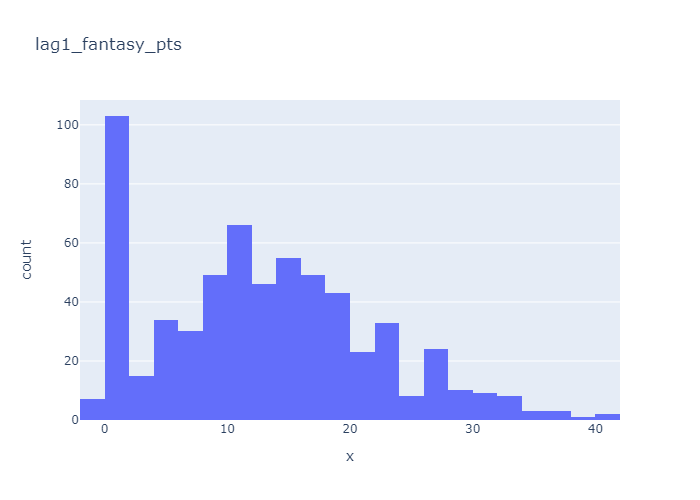

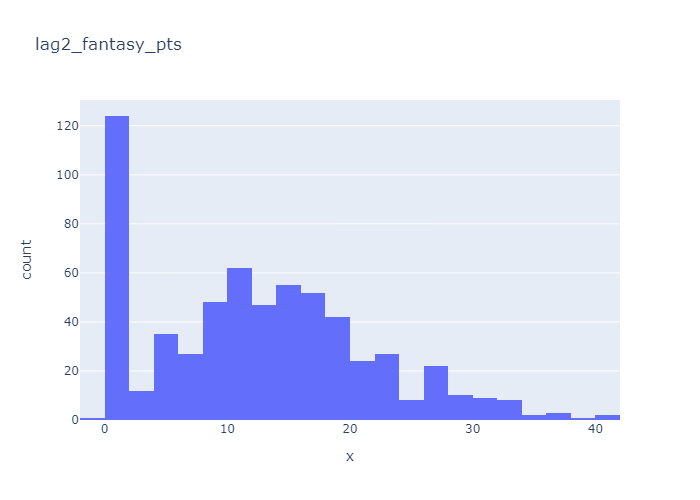

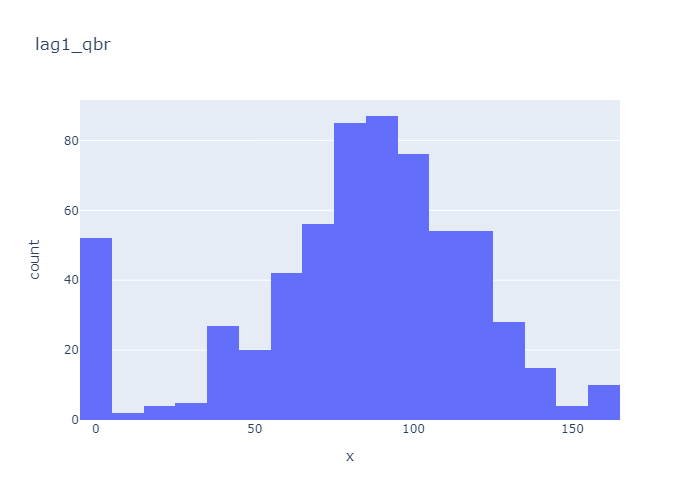

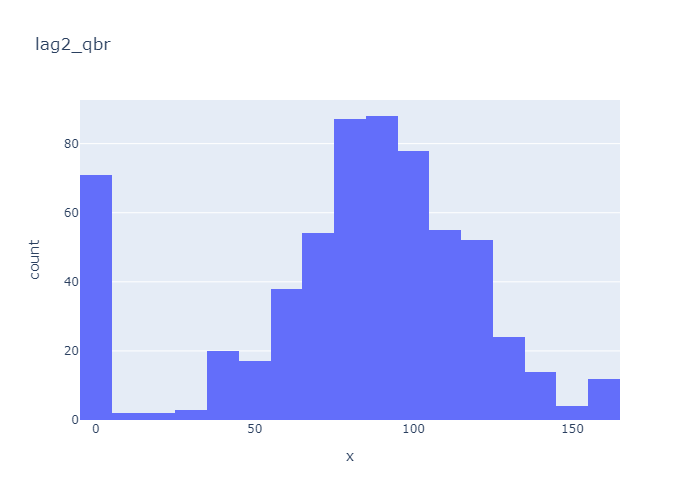

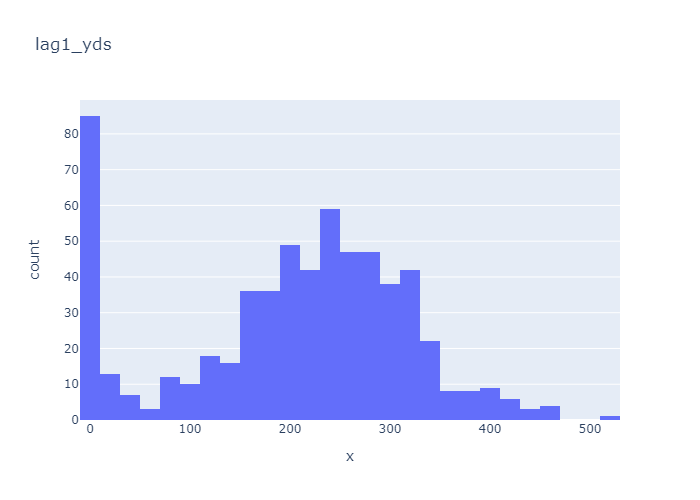

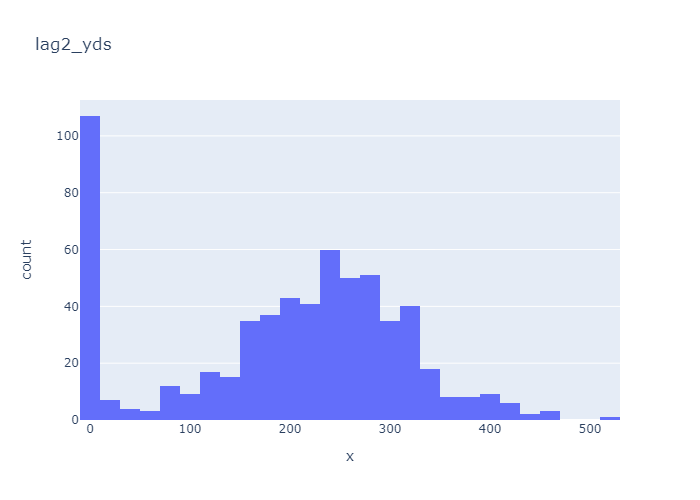

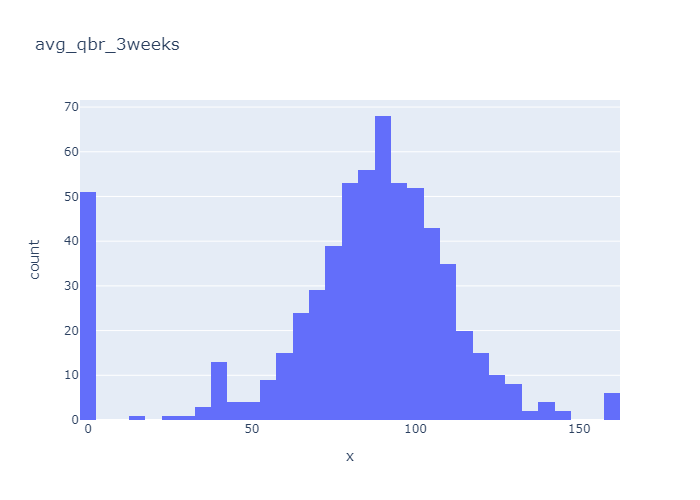

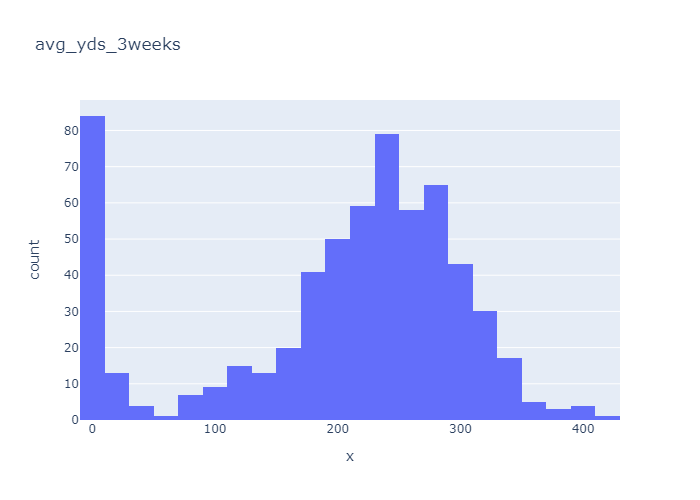

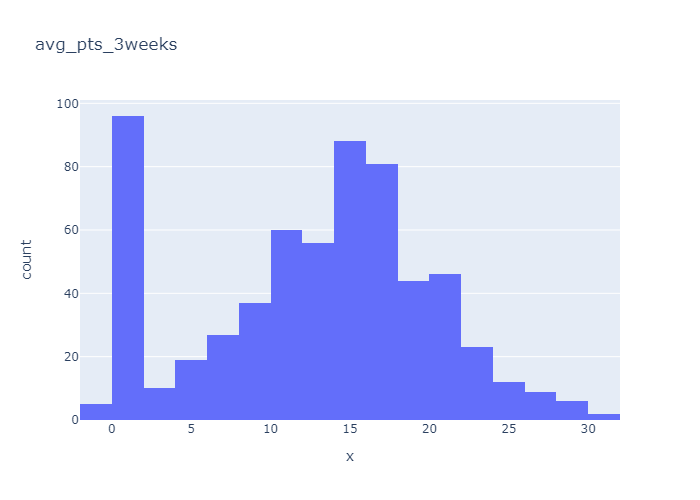

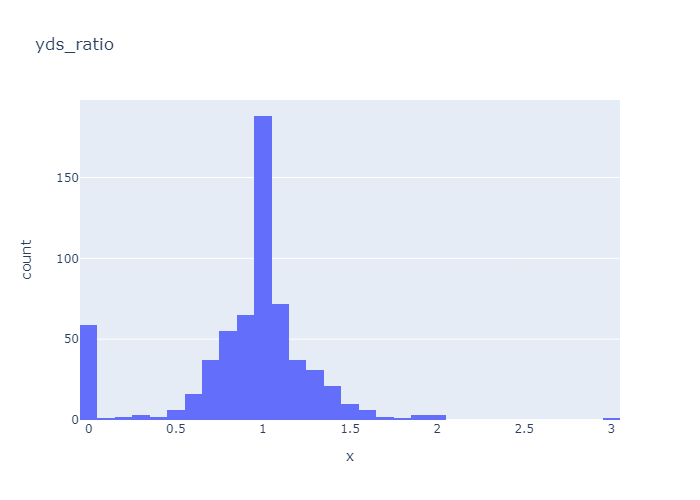

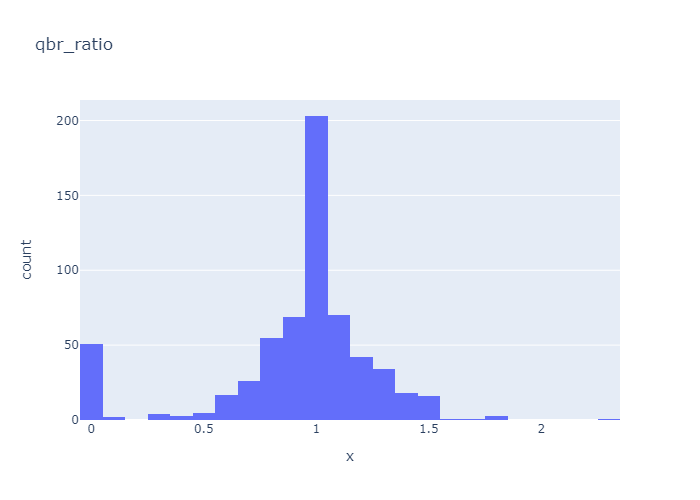

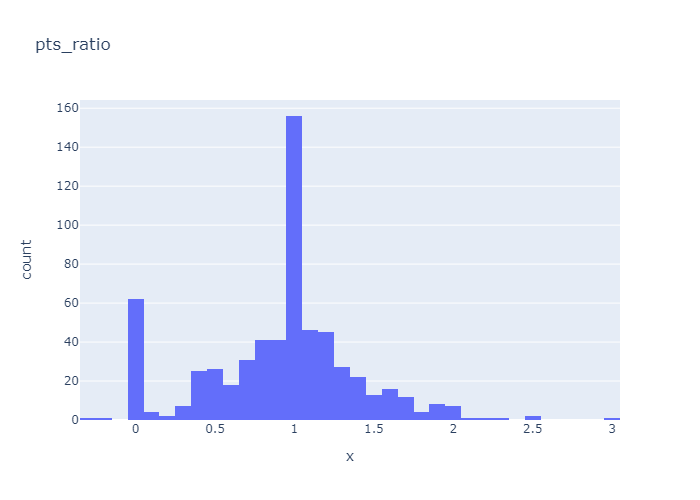

In [8]:
for i in lags+avgs+ratio:
    px.histogram(
        x=df_noNull.loc[:, i],
        title=i
    ).show(renderer='png')

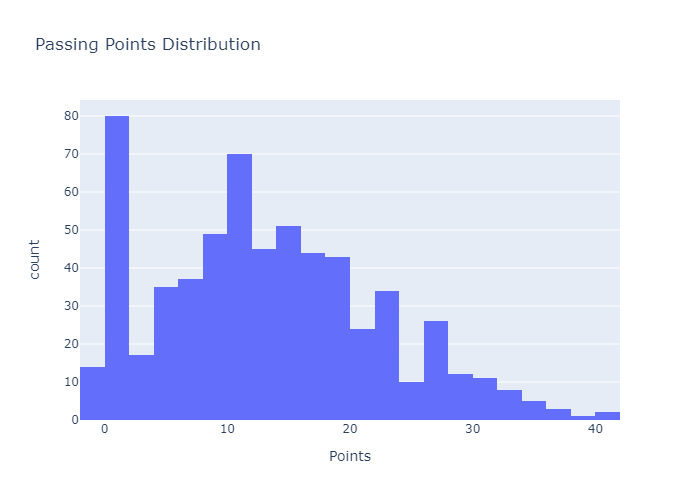

In [9]:
px.histogram(
    df_noNull,
    x='passing_fantasy_pts',
    title='Passing Points Distribution',
    labels={'passing_fantasy_pts': 'Points'}
).show(renderer='png')


### Building Candidate Models

In [10]:
# importing statsmodels packages
import statsmodels.api as sm


In [11]:
inputs = avgs + ratio + lags + factors + target + ['Week']

pass_mdl_data = df_noNull[inputs]

pass_mdl_data.head().T


,0,1,2,3,4
avg_qbr_3weeks,0.0,65.2,97.6,72.0,70.15
avg_yds_3weeks,0.0,225.0,277.6,323.0,269.5
avg_pts_3weeks,0.0,8.0,17.229,22.92,15.28
yds_ratio,0.0,1.0,1.0,1.0,0.801484
qbr_ratio,0.0,1.0,1.0,1.0,0.973628
pts_ratio,0.0,1.0,1.0,1.0,0.5
lag1_fantasy_pts,0.0,8.0,17.229,22.92,7.64
lag2_fantasy_pts,0.0,0.0,17.229,17.229,22.92
lag1_qbr,0.0,65.2,97.6,72.0,68.3
lag2_qbr,0.0,0.0,97.6,97.6,72.0


In [12]:
# OLS model
x = pass_mdl_data[avgs + ratio + lags]
x = sm.add_constant(x)
y = pass_mdl_data[target]

ols = sm.OLS(y, x)
res = ols.fit()


In [13]:
res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     passing_fantasy_pts   R-squared:                       0.304
Model:                             OLS   Adj. R-squared:                  0.291
Method:                  Least Squares   F-statistic:                     22.17
Date:                 Tue, 26 Apr 2022   Prob (F-statistic):           7.31e-41
Time:                         15:02:15   Log-Likelihood:                -2142.1
No. Observations:                  621   AIC:                             4310.
Df Residuals:                      608   BIC:                             4368.
Df Model:                           12                                         
Covariance Type:             nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                3.1915      1.068      2.987      0.003       1.093       5.290
avg_qbr_3weeks      -0.0037      0.045     -0.084      0.933      -0.092       0.084
avg_yds_3weeks       0.0019      0.021      0.089      0.929      -0.039       0.043
avg_pts_3weeks       0.5248      0.270      1.943      0.052      -0.006       1.055
yds_ratio            4.7539      2.961      1.605      0.109      -1.061      10.569
qbr_ratio           -1.1148      2.442     -0.457      0.648      -5.911       3.681
pts_ratio           -1.6601      2.489     -0.667      0.505      -6.549       3.229
lag1_fantasy_pts    -0.2239      0.189     -1.187      0.236      -0.594       0.147
lag2_fantasy_pts    -0.1944      0.120     -1.627      0.104      -0.429       0.040
lag1_qbr             0.0126      0.041      0.310      0.757      -0.068       0.093
lag2_qbr            -0.0215      0.018     -1.169      0.243      -0.058       0.015
lag1_yds             0.0112      0.016      0.694      0.488      -0.021       0.043
lag2_yds             0.0264      0.009      2.802      0.005       0.008       0.045
==============================================================================
Omnibus:                       35.981   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.776
Skew:                           0.620   Prob(JB):                     1.40e-09
Kurtosis:                       3.197   Cond. No.                     4.92e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.92e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

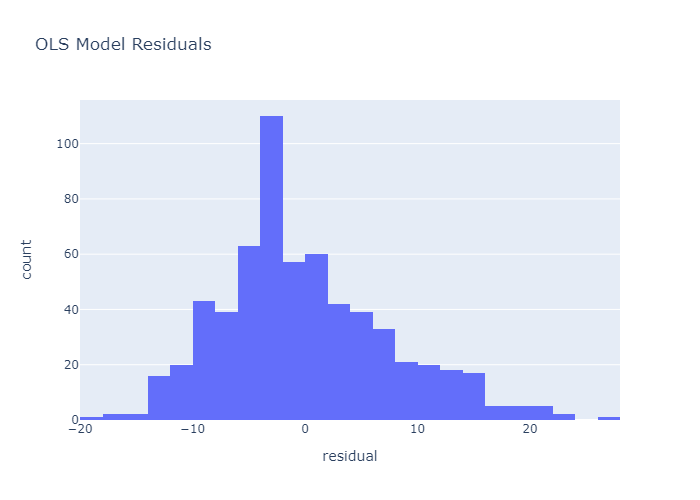

In [14]:
px.histogram(
    x=res.resid,
    title='OLS Model Residuals',
    labels={'x': 'residual'}
).show(renderer='png')


In [15]:
ols_results = pass_mdl_data.copy()

ols_results['fitted_val'] = res.fittedvalues
ols_results['resid'] = res.resid


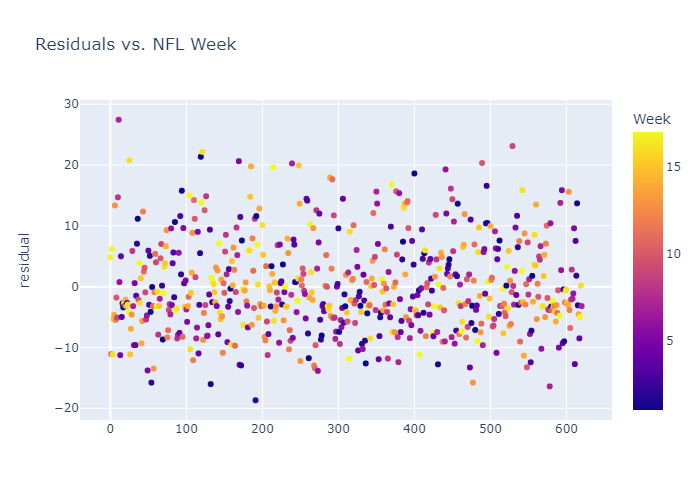

In [16]:
px.scatter(
    ols_results,
    y='resid',
    title='Residuals vs. NFL Week',
    labels={'index': '', 'resid': 'residual'},
    color='Week').show(renderer='png')


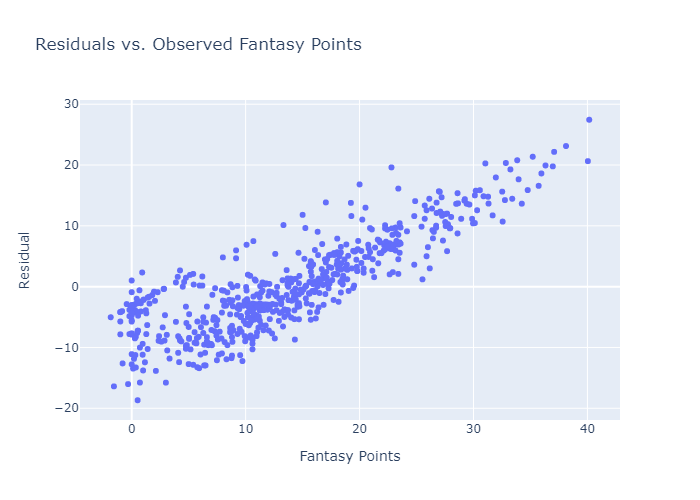

In [17]:
px.scatter(
    ols_results,
    x='passing_fantasy_pts',
    y='resid',
    title='Residuals vs. Observed Fantasy Points',
    labels={'passing_fantasy_pts': 'Fantasy Points', 'resid': 'Residual'}
).show(renderer='png')


In [18]:
# fit a regularized regression model

pens = [.001, .01, .1, .25, .5, 1, 10]

for i in pens:
    j = 0
    rmse_score = []
    mae_score = []
    while j < 10:

        # split the data into train/test
        y_train, y_test, x_train, x_test = train_test_split(
            pass_mdl_data[target], pass_mdl_data[avgs+ratio+lags], test_size=.25)

        elastic_net = sm.OLS(endog=y_train, exog=sm.add_constant(x_train)).fit_regularized(
            method='elastic_net',
            L1_wt=.5,
            alpha=i
        )

        net_preds = elastic_net.predict(sm.add_constant(x_test))
        rmse = np.sqrt(np.sum((y_test['passing_fantasy_pts'] - net_preds)**2)/len(y_test))
        mae = np.mean(np.abs(y_test['passing_fantasy_pts'] - net_preds))

        j += 1
        rmse_score.append(rmse)
        mae_score.append(mae)

    agg_rmse = np.mean(rmse_score)
    agg_mae = np.mean(mae_score)

    print(
        f"""RMSE: {agg_rmse}, MAE: {agg_mae} with pentalty {i}"""
    )


RMSE: 7.826625879859975, MAE: 6.1511077356490755 with pentalty 0.001
RMSE: 7.691751454895909, MAE: 6.164964857731093 with pentalty 0.01
RMSE: 7.878032698064104, MAE: 6.11897323182569 with pentalty 0.1
RMSE: 8.119922151626504, MAE: 6.339007400539347 with pentalty 0.25
RMSE: 7.721172181803588, MAE: 6.007105195885332 with pentalty 0.5
RMSE: 7.659663729330655, MAE: 5.9826413732365955 with pentalty 1
RMSE: 7.801763156245057, MAE: 6.046007375300499 with pentalty 10


In [19]:
final_elastic_net = sm.OLS(
    endog=y_train, exog=sm.add_constant(x_train)).fit_regularized(
    method='elastic_net',
    L1_wt=.5,
    alpha=1
)

In [20]:
dict(final_elastic_net.params)

{'const': 0.0,
 'avg_qbr_3weeks': 0.1077942971888775,
 'avg_yds_3weeks': 0.02548790536759162,
 'avg_pts_3weeks': -0.06769969571681239,
 'yds_ratio': 0.0,
 'qbr_ratio': 0.0,
 'pts_ratio': 0.0,
 'lag1_fantasy_pts': 0.0,
 'lag2_fantasy_pts': 0.0,
 'lag1_qbr': -0.0323376026967888,
 'lag2_qbr': -0.03858983648505408,
 'lag1_yds': 0.013943820598551199,
 'lag2_yds': 0.014197179892099168}

In [31]:
import json 

json.dump(dict(final_elastic_net.params), open('pass_model_params.json', 'w'))

### Two Step Model

- Step 1: GLM predicting score > _some threshold_
- Step 2: OLS predicting score conditional that score > _some threshold_

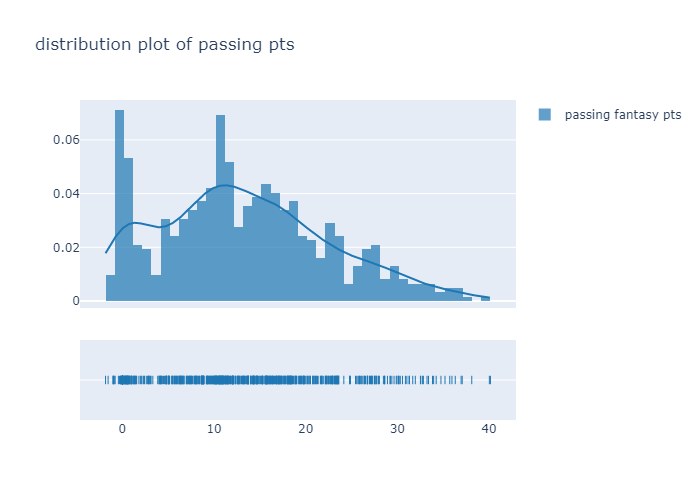

In [23]:
import plotly.figure_factory as ff

ff.create_distplot(
    [df_noNull['passing_fantasy_pts']],
    ['passing fantasy pts']
)\
    .update_layout(title='distribution plot of passing pts')\
    .show(renderer='png')


In [24]:
pd.qcut(df_noNull['passing_fantasy_pts'], q=5)


0        (4.76, 10.4]
1      (-1.841, 4.76]
2      (20.92, 40.16]
3        (4.76, 10.4]
4       (10.4, 14.92]
            ...      
616      (4.76, 10.4]
617    (-1.841, 4.76]
618    (-1.841, 4.76]
619      (4.76, 10.4]
620    (-1.841, 4.76]
Name: passing_fantasy_pts, Length: 621, dtype: category
Categories (5, interval[float64, right]): [(-1.841, 4.76] < (4.76, 10.4] < (10.4, 14.92] < (14.92, 20.92] < (20.92, 40.16]]

In [25]:
np.quantile(df_noNull['passing_fantasy_pts'], q=.2)


4.76

In [26]:
mdl_data2 = pass_mdl_data.copy()
mdl_data2['over5'] = np.where(mdl_data2['passing_fantasy_pts'] >= 5, 1, 0)

mdl_data2.head().T


,0,1,2,3,4
avg_qbr_3weeks,0.0,65.2,97.6,72.0,70.15
avg_yds_3weeks,0.0,225.0,277.6,323.0,269.5
avg_pts_3weeks,0.0,8.0,17.229,22.92,15.28
yds_ratio,0.0,1.0,1.0,1.0,0.801484
qbr_ratio,0.0,1.0,1.0,1.0,0.973628
pts_ratio,0.0,1.0,1.0,1.0,0.5
lag1_fantasy_pts,0.0,8.0,17.229,22.92,7.64
lag2_fantasy_pts,0.0,0.0,17.229,17.229,22.92
lag1_qbr,0.0,65.2,97.6,72.0,68.3
lag2_qbr,0.0,0.0,97.6,97.6,72.0


In [27]:
mdl_data2.groupby('over5')['Name'].count()/(127 + 494)


over5
0    0.204509
1    0.795491
Name: Name, dtype: float64

In [28]:
# Logistic regression for over/under 5 points

log_reg = sm.Logit(
    endog=mdl_data2['over5'],
    exog=sm.add_constant(mdl_data2[avgs + ratio + lags])
).fit()

log_reg.summary()


Optimization terminated successfully.
         Current function value: 0.284979
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  over5   No. Observations:                  621
Model:                          Logit   Df Residuals:                      608
Method:                           MLE   Df Model:                           12
Date:                Tue, 26 Apr 2022   Pseudo R-squ.:                  0.4375
Time:                        15:04:32   Log-Likelihood:                -176.97
converged:                       True   LL-Null:                       -314.59
Covariance Type:            nonrobust   LLR p-value:                 7.285e-52
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.2992      0.339     -3.838      0.000      -1.963      -0.636
avg_qbr_3weeks       0.0050      0.018      0.277      0.782      -0.030       0.040
avg_yds_3weeks      -0.0139      0.011     -1.308      0.191      -0.035       0.007
avg_pts_3weeks       0.2640      0.155      1.706      0.088      -0.039       0.567
yds_ratio            2.4929      1.348      1.849      0.064      -0.150       5.136
qbr_ratio           -0.5513      0.950     -0.580      0.562      -2.414       1.311
pts_ratio           -0.9292      1.189     -0.782      0.435      -3.259       1.401
lag1_fantasy_pts    -0.0270      0.109     -0.249      0.804      -0.240       0.186
lag2_fantasy_pts    -0.0653      0.066     -0.987      0.324      -0.195       0.064
lag1_qbr            -0.0122      0.018     -0.690      0.490      -0.047       0.022
lag2_qbr            -0.0068      0.007     -0.937      0.349      -0.021       0.007
lag1_yds             0.0085      0.008      0.997      0.319      -0.008       0.025
lag2_yds             0.0136      0.004      3.039      0.002       0.005       0.022
====================================================================================
"""

In [29]:
# OLS for < 5 points
less5 = mdl_data2.loc[mdl_data2['over5'] == 0, :]

less5_reg = sm.OLS(less5['passing_fantasy_pts'],
                   sm.add_constant(less5[avgs + ratio + lags])).fit()
less5_reg.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     passing_fantasy_pts   R-squared:                       0.270
Model:                             OLS   Adj. R-squared:                  0.193
Method:                  Least Squares   F-statistic:                     3.516
Date:                 Tue, 26 Apr 2022   Prob (F-statistic):           0.000191
Time:                         15:04:34   Log-Likelihood:                -223.37
No. Observations:                  127   AIC:                             472.7
Df Residuals:                      114   BIC:                             509.7
Df Model:                           12                                         
Covariance Type:             nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.4474      0.234      1.912      0.058      -0.016       0.911
avg_qbr_3weeks      -0.0094      0.017     -0.546      0.586      -0.043       0.025
avg_yds_3weeks       0.0120      0.012      1.037      0.302      -0.011       0.035
avg_pts_3weeks      -0.0131      0.182     -0.072      0.942      -0.373       0.347
yds_ratio           -0.2293      0.837     -0.274      0.784      -1.886       1.428
qbr_ratio            0.7862      0.594      1.322      0.189      -0.391       1.964
pts_ratio           -0.3286      0.739     -0.444      0.658      -1.793       1.136
lag1_fantasy_pts     0.0114      0.134      0.085      0.932      -0.254       0.276
lag2_fantasy_pts     0.1790      0.097      1.839      0.068      -0.014       0.372
lag1_qbr             0.0062      0.018      0.349      0.728      -0.029       0.042
lag2_qbr             0.0037      0.006      0.644      0.521      -0.008       0.015
lag1_yds            -0.0003      0.010     -0.027      0.979      -0.021       0.020
lag2_yds            -0.0162      0.006     -2.892      0.005      -0.027      -0.005
==============================================================================
Omnibus:                       12.380   Durbin-Watson:                   2.322
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               12.955
Skew:                           0.736   Prob(JB):                      0.00154
Kurtosis:                       3.532   Cond. No.                     1.85e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.85e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [30]:
# OLS for > 5 points
over5 = mdl_data2.loc[mdl_data2['over5'] == 1, :]

over5_reg = sm.OLS(over5['passing_fantasy_pts'],
                   sm.add_constant(over5[avgs + ratio + lags])).fit()
over5_reg.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     passing_fantasy_pts   R-squared:                       0.061
Model:                             OLS   Adj. R-squared:                  0.038
Method:                  Least Squares   F-statistic:                     2.613
Date:                 Tue, 26 Apr 2022   Prob (F-statistic):            0.00220
Time:                         15:04:38   Log-Likelihood:                -1684.7
No. Observations:                  494   AIC:                             3395.
Df Residuals:                      481   BIC:                             3450.
Df Model:                           12                                         
Covariance Type:             nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               12.9949      2.241      5.797      0.000       8.591      17.399
avg_qbr_3weeks       0.0016      0.065      0.024      0.981      -0.126       0.130
avg_yds_3weeks       0.0001      0.027      0.004      0.997      -0.052       0.053
avg_pts_3weeks       0.2295      0.310      0.740      0.460      -0.380       0.839
yds_ratio            0.4850      4.773      0.102      0.919      -8.893       9.863
qbr_ratio           -2.2882      4.453     -0.514      0.608     -11.038       6.462
pts_ratio           -1.1133      3.269     -0.341      0.734      -7.536       5.309
lag1_fantasy_pts    -0.1850      0.222     -0.833      0.405      -0.622       0.252
lag2_fantasy_pts    -0.0978      0.129     -0.757      0.449      -0.352       0.156
lag1_qbr             0.0398      0.060      0.660      0.510      -0.079       0.158
lag2_qbr            -0.0311      0.024     -1.300      0.194      -0.078       0.016
lag1_yds             0.0126      0.022      0.578      0.563      -0.030       0.055
lag2_yds             0.0131      0.010      1.299      0.195      -0.007       0.033
==============================================================================
Omnibus:                       33.222   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.828
Skew:                           0.686   Prob(JB):                     3.70e-09
Kurtosis:                       2.952   Cond. No.                     7.70e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.7e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""